In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Visualizing the data with attention edges

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 3/12/2021

__Last run:__ 4/14/2021

__Goals:__
We visualize the input graph with the edge transparency controlled by the attention weights.

Let's train a GNN for a few epochs to learn some attention.

In [2]:
from n2j.trainval_data.raytracers.cosmodc2_raytracer import CosmoDC2Raytracer
from n2j.trainer import Trainer

IN_DIR = '../n2j/data'  # where raw data lies
TRAIN_HP = [10327, 10450]
VAL_HP = [9559]
N_TRAIN = 200
N_VAL = 100
BATCH_SIZE = min(N_TRAIN//5, 25)
CHECKPOINT_PATH = None
SUB_TARGET = ['final_kappa', ]  # 'final_gamma1', 'final_gamma2']
if False:
    ##############
    # Labels (Y) #
    ##############
    # Explicitly sample kappas for ~1000 sightlines first (slow)
    if False:
        kappa_sampler = CosmoDC2Raytracer(in_dir=IN_DIR,
                                          out_dir='../kappa_sampling',
                                          fov=0.85,
                                          healpix=10450,
                                          n_sightlines=1000,  # keep this small
                                          mass_cut=11.0,
                                          n_kappa_samples=1000)
        kappa_sampler.parallel_raytrace()
        kappa_sampler.apply_calibration()
    # Use this to infer the mean kappa contribution of new sightlines
    for hp in TRAIN_HP:
        train_Y_generator = CosmoDC2Raytracer(in_dir=IN_DIR,
                                              out_dir=f'demo_Y_{hp}',
                                              fov=0.85,
                                              healpix=hp,
                                              n_sightlines=N_TRAIN,  # many more LOS
                                              mass_cut=11.0,
                                              n_kappa_samples=0,
                                              kappa_sampling_dir='../kappa_sampling')  # no sampling
        train_Y_generator.parallel_raytrace()
        train_Y_generator.apply_calibration()
    for hp in VAL_HP:
        # Use on a different healpix
        val_Y_generator = CosmoDC2Raytracer(in_dir=IN_DIR,
                                            out_dir=f'demo_Y_{hp}',
                                            fov=0.85,
                                            healpix=hp,
                                            n_sightlines=N_VAL,  # many more LOS
                                            mass_cut=11.0,
                                            n_kappa_samples=0,
                                            kappa_sampling_dir='../kappa_sampling')  # no sampling
        val_Y_generator.parallel_raytrace()
        val_Y_generator.apply_calibration()

##############
# Graphs (X) #
##############

features = ['galaxy_id', 'ra', 'dec', 'redshift']
features += ['ra_true', 'dec_true', 'redshift_true']
features += ['ellipticity_1_true', 'ellipticity_2_true']
features += ['bulge_to_total_ratio_i']
features += ['ellipticity_1_bulge_true', 'ellipticity_1_disk_true']
features += ['ellipticity_2_bulge_true', 'ellipticity_2_disk_true']
features += ['shear1', 'shear2', 'convergence']
features += ['size_bulge_true', 'size_disk_true', 'size_true']
features += ['mag_{:s}_lsst'.format(b) for b in 'ugrizY']
# Features to train on
sub_features = ['ra_true', 'dec_true']
sub_features += ['size_true']
sub_features += ['mag_{:s}_lsst'.format(b) for b in 'i']
trainer = Trainer('cuda', checkpoint_dir='demo_run', seed=1113)

trainer.load_dataset(dict(features=features,
                          raytracing_out_dirs=[f'demo_Y_{hp}' for hp in TRAIN_HP],
                          healpixes=TRAIN_HP,
                          n_data=[N_TRAIN]*len(TRAIN_HP),
                          aperture_size=1.0,
                          stop_mean_std_early=True,
                          in_dir=IN_DIR),
                     sub_features=sub_features,
                     sub_target=SUB_TARGET,
                     is_train=True,
                     batch_size=BATCH_SIZE,
                     )
# FIXME: must be run after train
trainer.load_dataset(dict(features=features,
                          raytracing_out_dirs=[f'demo_Y_{hp}' for hp in VAL_HP],
                          healpixes=VAL_HP,
                          n_data=[N_VAL]*len(VAL_HP),
                          aperture_size=1.0,
                          in_dir=IN_DIR),
                     sub_features=sub_features,
                     sub_target=SUB_TARGET,
                     is_train=False,
                     batch_size=BATCH_SIZE,  # FIXME: must be same as train
                     )
trainer.configure_loss_fn('FullRankGaussianNLL')
trainer.configure_model('GATNet',
                        {'hidden_channels': 64,
                         'n_layers': 3,
                         'dropout': 0.0,
                         'kwargs': {'concat': False, 'heads': 2}})
trainer.configure_optim(20,
                        {'lr': 1.e-5, 'weight_decay': 1.e-5},
                        {'factor': 0.75, 'min_lr': 1.e-7, 'patience': 200, 'verbose': True})
if CHECKPOINT_PATH:
    trainer.load_state(CHECKPOINT_PATH)
trainer.train(n_epochs=5, eval_every=2)
print(trainer)
# Save final validation metrics
summary = trainer.eval_posterior(epoch_i=trainer.epoch,
                                 n_samples=200,
                                 n_mc_dropout=20,
                                 on_train=False)
np.save(os.path.join(trainer.checkpoint_dir, 'summary.npy'), summary)


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]

{"X_dim": 4, "sub_features": ["ra_true", "dec_true", "size_true", "mag_i_lsst"], "sub_target": ["final_kappa"], "Y_dim": 1, "out_dim": 2, "batch_size": 25, "epoch": 4, "n_epochs": 5, "hidden_channels": 64, "n_layers": 3, "dropout": 0.0, "kwargs": {"concat": false, "heads": 2}, "lr": 1e-05, "weight_decay": 1e-05, "factor": 0.75, "min_lr": 1e-07, "patience": 200, "verbose": true, "nll_type": "FullRankGaussianNLL"}


Which sightlines should we plot? Maybe we want to check out the overdense ones, with high $\kappa$.

In [3]:
summary = np.load('demo_run/summary.npy', allow_pickle=True).item()

for i, k in enumerate(summary['y_val'][:, 0]):
    if k > 0.05:
        print(i, k)

0 0.08896373212337494
9 0.05672276020050049
17 0.11693473905324936
78 0.0725027471780777
87 0.0900680348277092
97 0.10451170802116394


Let's now color the nodes by the redshift.

2.013376235961914


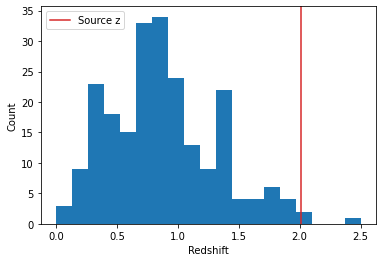

In [12]:
data_i = 0
# Make sure dataset is not standardized and is in real units
trainer.val_dataset.transform_X = None
trainer.val_dataset.transform_Y = None
sample_data = trainer.val_dataset[data_i]
pointings = trainer.val_dataset.Y
z_src = pointings.iloc[data_i]['z']
print(z_src)
z = sample_data.x[:, 3].numpy()
z[0] = z_src
plt.xlabel('Redshift')
plt.ylabel('Count')
plt.hist(z, bins=np.linspace(0, 2.5, 20))
plt.axvline(z_src, color='tab:red', label='Source z')
plt.legend()

We can additionally scale the node size by the (inverse) i-band magnitude.

torch.Size([228, 26]) torch.Size([2, 10428])
tensor([[ 0.0890, -0.0345,  0.0002]])


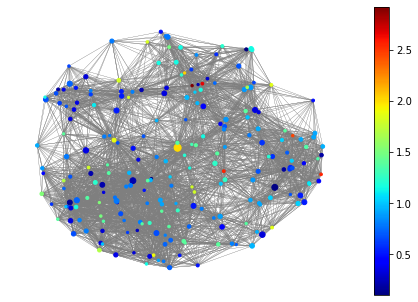

In [5]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib

data_i = 0
cmap = matplotlib.cm.get_cmap('jet')
sample_data = trainer.val_dataset[data_i]
pointings = trainer.val_dataset.Y
sample_networkx = to_networkx(sample_data)
n_nodes = sample_data.x.shape[0]
# Color by redshift
z = sample_data.x[:, 3].numpy()
z[0] = pointings.iloc[data_i]['z']
scaled_z = (z - z.min())/(z.max() - z.min())  # scale 0 to 1 for colormap
node_color = cmap(scaled_z)
# Make brighter nodes bigger
mag = -sample_data.x[:, -3].numpy()
mag[0] = np.mean(mag[1:])
node_size = (mag - mag.min())/(mag.max() - mag.min())*30 + 5
node_size[0] = 50

nx.draw(sample_networkx, pos=dict(zip(range(n_nodes), sample_data.x[:, 4:6].tolist())),
        width=0.2, edge_color='tab:gray', arrowsize=1, alpha=1.0, 
        node_color=node_color, node_size=node_size)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
sm.set_array([])
plt.colorbar(sm)

print(sample_data.x.shape, sample_data.edge_index.shape)
print(sample_data.y)

In [6]:
attention_edge_index = summary['edge_index']
sample_data = trainer.val_dataset[data_i]

# Get a particular subgraph in this dataset
subgraph_edge_index = sample_data.edge_index.cpu().numpy()
# Find idx of the first edge of the subgraph
first_i, first_j = subgraph_edge_index[:, 0]
print(first_i, first_j)
first_idx = np.where((attention_edge_index[0, :] == first_i) & (attention_edge_index[1, :] == first_j))[0][0]
# Find idx of the last edge of the subgraph
last_i, last_j = subgraph_edge_index[:, -1]
print(last_i, last_j)
last_idx = np.where((attention_edge_index[0, :] == last_i) & (attention_edge_index[1, :] == last_j))[0][0]
print(first_idx, last_idx)

# Slice the attention weights for this subgraph (averaged across the 4 heads)
attention_weights = summary['w'][first_idx:last_idx+1, :].mean(axis=-1)

16 93
215 37
0 10427


In [7]:
summary['edge_index'].shape, summary['w'].shape, subgraph_edge_index.shape, attention_weights.shape

((2, 562686), (562686, 2), (2, 10428), (10428,))

In [8]:
attention_edge_index[0, :]

array([  16,   81,   29, ..., 3963, 3983, 4029])

In [9]:
# Add attention weights from node a node b to weights from node b to node a
plot_edge = np.zeros(subgraph_edge_index.shape[1]).astype(bool)
for i in range(subgraph_edge_index.shape[1]):
    a, b = subgraph_edge_index[:, i]
    if a < b:
        plot_edge[i] = True
        find = np.where((attention_edge_index[0, :] == b) & (attention_edge_index[1, :] == a))[0]
        if len(find) == 0:
            continue
        else:
            reverse_i = find[0]
            attention_weights[i] += attention_weights[reverse_i]

torch.Size([228, 26]) torch.Size([2, 10428])
tensor([[ 0.0890, -0.0345,  0.0002]])


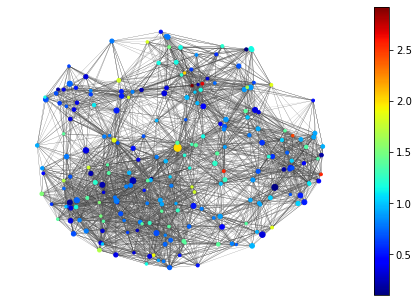

In [11]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib

data_i = 0
cmap = matplotlib.cm.get_cmap('jet')
sample_data = trainer.val_dataset[data_i]
sample_networkx = to_networkx(sample_data)
n_nodes = sample_data.x.shape[0]
# Color by redshift
z = sample_data.x[:, 3].numpy()
z[0] = pointings.iloc[data_i]['z']
scaled_z = (z - z.min())/(z.max() - z.min())  # scale 0 to 1 for colormap
node_color = cmap(scaled_z)
# Make brighter nodes bigger
mag = -sample_data.x[:, -3].numpy()
mag[0] = np.mean(mag[1:])
node_size = (mag - mag.min())/(mag.max() - mag.min())*30 + 5
node_size[0] = 50
# Control edge transparency with attention weights
edge_color = attention_weights[plot_edge]
edge_color = edge_color/np.sum(edge_color)
edge_cmap = 'greys'

nx.draw(sample_networkx, pos=dict(zip(range(n_nodes), sample_data.x[:, 4:6].tolist())),
        width=0.2,
        # Edge
        edge_color=edge_color, 
        edge_cmap=matplotlib.cm.get_cmap('Greys_r'), 
        edgelist=np.array(sample_networkx.edges())[plot_edge, :],
        arrowsize=1,  
        # Node
        node_color=node_color, node_size=node_size)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
sm.set_array([])
plt.colorbar(sm)

print(sample_data.x.shape, sample_data.edge_index.shape)
print(sample_data.y)

In [ ]:
_ = plt.hist(attention_weights, density=True, bins=20)

In [ ]:
_ = plt.hist(edge_color, density=True, bins=20)

In [ ]:
edge_mean = np.median(edge_color)
edge_cmap = matplotlib.cm.get_cmap('Greys_r')
color_mean = edge_cmap(edge_mean)

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib

data_i = 0
cmap = matplotlib.cm.get_cmap('jet')
sample_data = trainer.val_dataset[data_i]
sample_networkx = to_networkx(sample_data)
n_nodes = sample_data.x.shape[0]
# Color by redshift
z = sample_data.x[:, 3].numpy()
z[0] = pointings.iloc[data_i]['z']
scaled_z = (z - z.min())/(z.max() - z.min())  # scale 0 to 1 for colormap
node_color = cmap(scaled_z)
# Make brighter nodes bigger
mag = -sample_data.x[:, -3].numpy()
mag[0] = np.mean(mag[1:])
node_size = (mag - mag.min())/(mag.max() - mag.min())*30 + 5
node_size[0] = 50

nx.draw(sample_networkx, pos=dict(zip(range(n_nodes), sample_data.x[:, 4:6].tolist())),
        width=0.2, 
        edge_color=color_mean, arrowsize=1,
        node_color=node_color, node_size=node_size)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=z.min(), vmax=z.max()))
sm.set_array([])
plt.colorbar(sm)

print(sample_data.x.shape, sample_data.edge_index.shape)
print(sample_data.y)